In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('data/corpus_el_labelled.csv', sep=';')
df.sample(10)

,el,author
299,EMBARGOT Εμπάργκο μετάδοσης έως τις 10 π.μ. CE...,google
29,8 Ιουλίου 2021 Το Διοικητικό Συμβούλιο της ΕΚΤ...,google
1059,Στη σημερινή συνεδρίαση το Διοικητικό Συμβούλι...,google
905,Οι όροι εντολής του Ευρωσυστήματος για τον εντ...,google
599,Το δεύτερο εξάμηνο του 2009 αποσύρθηκαν από τη...,google
261,Περισσότεροι από 5.500 μαθητές ηλικίας μεταξύ ...,google
386,"Κατά τη σημερινή του συνεδρίαση, η οποία πραγμ...",translator
477,"Στη σημερινή συνεδρίαση, που πραγματοποιήθηκε ...",google
361,EMBARGOT Εμπάργκο μεταφοράς έως τις 11.30 π.μ....,google
1089,Το Διοικητικό Συμβούλιο της ΕΚΤ αποφάσισε να μ...,google


In [3]:
enc = LabelEncoder()
enc.fit(df['author'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['author'] = enc.transform(df['author'])
encoded_labels

{'google': 0, 'translator': 1}

In [4]:
df.isna().sum()

el        0
author    0
dtype: int64

In [9]:
X = df[['el']]
y = df['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1032, 1), (258, 1), (1032,), (258,))

In [10]:
from nltk.corpus import stopwords
stopwords_el = stopwords.words('greek')

vect_2grams = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=1000, stop_words=stopwords_el)
vect_3grams = CountVectorizer(analyzer='word', ngram_range=(3, 3), max_features=1000, stop_words=stopwords_el)

ct = ColumnTransformer([
    ('vect_wd_2', vect_2grams, 'el'),
    ('vect_wd_3', vect_3grams, 'el'),
], remainder='passthrough', n_jobs=-1)

svm = SVC(kernel='linear', random_state=97)

pipe = make_pipeline(ct, svm)

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.1, 1, 10, 100],
}

gs = GridSearchCV(
    pipe, param_grid, 
    cv=10, scoring='f1_macro', 
    n_jobs=-1, refit=True, 
    verbose=10, error_score='raise'
)

gs.fit(X_train, y_train)

print('-'*48)
print('Best params:', gs.best_params_)
print('Best f1-score:', round(gs.best_score_, 3))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
------------------------------------------------
Best params: {'svc__C': 0.1, 'svc__gamma': 0.1}
Best f1-score: 0.897


In [11]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       122
           1       0.90      0.92      0.91       136

    accuracy                           0.90       258
   macro avg       0.90      0.90      0.90       258
weighted avg       0.90      0.90      0.90       258



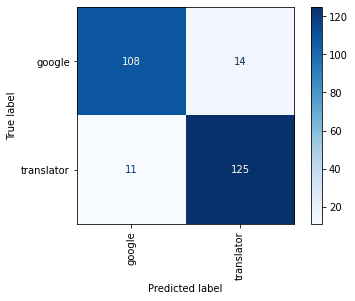

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90)
disp.ax_.set_facecolor('red');

In [13]:
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print(f"{mean:0.3f} (+/-{2 * std:0.03f}) for {params}")

0.897 (+/-0.068) for {'svc__C': 0.1, 'svc__gamma': 0.1}
0.897 (+/-0.068) for {'svc__C': 0.1, 'svc__gamma': 1}
0.897 (+/-0.068) for {'svc__C': 0.1, 'svc__gamma': 10}
0.897 (+/-0.068) for {'svc__C': 0.1, 'svc__gamma': 100}
0.890 (+/-0.072) for {'svc__C': 1, 'svc__gamma': 0.1}
0.890 (+/-0.072) for {'svc__C': 1, 'svc__gamma': 1}
0.890 (+/-0.072) for {'svc__C': 1, 'svc__gamma': 10}
0.890 (+/-0.072) for {'svc__C': 1, 'svc__gamma': 100}
0.890 (+/-0.070) for {'svc__C': 10, 'svc__gamma': 0.1}
0.890 (+/-0.070) for {'svc__C': 10, 'svc__gamma': 1}
0.890 (+/-0.070) for {'svc__C': 10, 'svc__gamma': 10}
0.890 (+/-0.070) for {'svc__C': 10, 'svc__gamma': 100}
0.890 (+/-0.070) for {'svc__C': 100, 'svc__gamma': 0.1}
0.890 (+/-0.070) for {'svc__C': 100, 'svc__gamma': 1}
0.890 (+/-0.070) for {'svc__C': 100, 'svc__gamma': 10}
0.890 (+/-0.070) for {'svc__C': 100, 'svc__gamma': 100}


In [14]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):

    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))

    _, ax = plt.subplots(1, 1) # Plot Grid search scores

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title('Grid Search scores')
    ax.set_xlabel(name_param_1)
    ax.set_ylabel('10-fold CV f1 macro avg.')
    ax.legend(loc='best')
    ax.grid('on')

In [15]:
plot_grid_search(gs.cv_results_, param_grid['svc__C'], param_grid['tfidfvectorizer__ngram_range'], r'SVC $C$', r'word $n$-grams')

KeyError: 'tfidfvectorizer__ngram_range'